In [1]:
import os, sys, csv

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import cv2 as cv

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [3]:
gpu = torch.cuda.is_available()
device = torch.device("cpu")

if gpu:
    print("use gpu")
    device = torch.device("cuda:0")

use gpu


In [9]:
# BoostNet Dataset
# from SpineWeb dataset16
# link: http://spineweb.digitalimaginggroup.ca/spineweb/index.php?n=Main.Datasets

class BoostNetDataset(torch.utils.data.Dataset):
    def __init__(self, path, train=True):
        self.images = []
        self.labels = []
        
        if train:
            image_path = path + "/data/training/"
            names = csv.reader(open(path + "/labels/training/filenames.csv", 'r'))
            landmarks = csv.reader(open(path + "/labels/training/landmarks.csv", 'r'))
        else:
            image_path = path + "/data/test/"
            names = csv.reader(open(path + "/labels/test/filenames.csv", 'r'))
            landmarks = csv.reader(open(path + "/labels/test/landmarks.csv", 'r'))
        
        for landmark_each_image in landmarks:
            coordinate_list = []
            for coordinate in landmark_each_image:
                coordinate_list.append(float(coordinate))
            self.labels.append(torch.Tensor(coordinate_list))

        for i, name in enumerate(names):
            origin_image = cv.imread(image_path + name[0], cv.IMREAD_GRAYSCALE)
            
            target_height = 256
            target_width = 128
            image = np.zeros((target_height, target_width), np.uint8)
            cv.resize(origin_image, (target_width, target_height), image)
            
            image = np.reshape(image, (1, image.shape[0], image.shape[1]))
            image_tensor = torch.from_numpy(image).float()
            
            self.images.append(image_tensor)

        
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        
        return image, label
    
    def __len__(self):
        return len(self.images)

In [5]:
# define network

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        
        # the first 4-parts convolutional layers in paper to extract features
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=1, padding=(1,2))
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=3)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=3)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        
        return x 

class BoostLayer(nn.Module):
    def __init__(self, input_channel, output_channel, h, w):
        super(BoostLayer, self).__init__()
        self.encoder_weight = nn.Parameter(torch.randn(output_channel, input_channel, 3, 3))
        
        self.average = torch.zeros((input_channel, h, w), requires_grad=False).to(device)
        self.sigma_square = torch.zeros((input_channel, h, w), requires_grad=False).to(device)
        
    def update_avg_cov(self, avg, cov):
        assert(avg.shape == self.average.shape)
        assert(cov.shape == self.sigma_square.shape)
        
        self.average = avg
        self.sigma_square = cov
    
    def forward(self, x):
            
        encode_x = nn.functional.conv2d(x, self.encoder_weight, stride=1, padding=1)
    
        decoder_weight = self.encoder_weight.transpose(0, 1).transpose(2, 3).contiguous()
        
        r = nn.functional.conv2d(encode_x, decoder_weight, stride=1, padding=1)

        epsilon = (x - r).pow(2)
        
        x_hat = x.clone()
        
        batch_size = x.shape[0]
        
        for i in range(batch_size):
            outliers = epsilon[i] > self.sigma_square.mul(4)
            x_hat[i][outliers] = self.average[outliers]
    
        y = nn.functional.conv2d(x_hat, self.encoder_weight, stride=1, padding=1)
        return y
        

class MultiOutputLayer(nn.Module):
    def __init__(self, channel, h, w):
        super(MultiOutputLayer, self).__init__()
        self.fc = nn.Linear(channel * h * w, 136)
        self.dm = self.generate_dm().to(device)
        
    def generate_dm(self):
        landmark_cnt = 68
        dm = torch.zeros([landmark_cnt, landmark_cnt])

        for i in range(landmark_cnt):
            # horizontal
            if i % 2 == 0:
                dm[i, i + 1] = dm[i + 1, i] = 1
            else:
                dm[i, i - 1] = dm[i - 1, i] = 1
            # vertical
            if i < landmark_cnt - 2:
                dm[i, i + 2] = dm[i + 2, i] = 1
            if i > 1:
                dm[i, i - 2] = dm[i - 2, i] = 1
            # diagonal
            if i % 4 == 0:
                dm[i, i + 3] = dm[i + 3, i] = 1
            if i % 4 == 2:
                dm[i, i - 1] = dm[i - 1, i] = 1
        return dm
    
    def forward(self, x):
        x = x.view(-1, self.fc.weight.shape[1])
        x = self.fc(x)
        
        x = x.view(-1, 2, 68)
        
        mul_x = x.clone()
        for i, _ in enumerate(x):
            mul_x[i] = x[i].mm(self.dm)
        
        active_x = mul_x.clone()
        active_x[mul_x<0] = 0
        
        self.dm.detach_()
        
        return active_x
        
class BoostNet(nn.Module):
    def __init__(self):
        super(BoostNet, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.boost1 = BoostLayer(256, 400, 28, 14)
        self.boost2 = BoostLayer(400, 400, 28, 14)
        self.multi_output = MultiOutputLayer(400, 28, 14)
        
        self.average = [
            torch.zeros((256, 28, 14)).to(device),
            torch.zeros((400, 28, 14)).to(device),
        ]
        
        self.sigma = [
            torch.zeros((256, 28, 14)).to(device),
            torch.zeros((400, 28, 14)).to(device),
        ]
        
        self.count = 0
        
    def update(self, x, index):
        plus = torch.add(x.mean(0), self.average[index].mul(self.count))
        self.average[index] = plus.div(self.count + 1)
        self.sigma[index] = (x - self.average[index]).pow(2).mean(0)
                         
    def forward(self, x):
        x = self.feature_extractor(x)
        
        self.update(x, 0)
        self.boost1.update_avg_cov(self.average[0], self.sigma[0])
                         
        x = self.boost1(x)

        self.update(x, 1)
        self.boost2.update_avg_cov(self.average[1], self.sigma[1])

        x = self.boost2(x)
        x = self.multi_output(x)
        
        x = x.view(-1, 136)
    
        self.count += 1
        
        self.average[0].detach_()
        self.average[1].detach_()
        
        self.sigma[0].detach_()
        self.sigma[1].detach_()
        
    
        return x

In [10]:
path = "E:/Workspace/AASCE2019/boostnet_labeldata"
train_data = BoostNetDataset(path, train=True)
test_data = BoostNetDataset(path, train=False)

batch = 4
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch,
                                         shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch,
                                         shuffle=True, num_workers=0)


print("number of batches(training): ", len(train_loader))
print("number of batches(testing): ", len(test_loader))

number of batches(training):  121
number of batches(testing):  32


In [18]:
net = BoostNet().to(device)

for name, param in net.named_parameters():
    print(name, param.size())


dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
out = net(images)

print(out.shape)
print(labels.shape)

feature_extractor.conv1.weight torch.Size([64, 1, 7, 7])
feature_extractor.conv1.bias torch.Size([64])
feature_extractor.conv2.weight torch.Size([64, 64, 3, 3])
feature_extractor.conv2.bias torch.Size([64])
feature_extractor.conv3.weight torch.Size([128, 64, 3, 3])
feature_extractor.conv3.bias torch.Size([128])
feature_extractor.conv4.weight torch.Size([256, 128, 5, 5])
feature_extractor.conv4.bias torch.Size([256])
boost1.encoder_weight torch.Size([400, 256, 3, 3])
boost2.encoder_weight torch.Size([400, 400, 3, 3])
multi_output.fc.weight torch.Size([136, 156800])
multi_output.fc.bias torch.Size([136])
torch.Size([4, 136])
torch.Size([4, 136])


In [12]:
print(net)

BoostNet(
  (feature_extractor): FeatureExtractor(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 2))
    (pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (pool4): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (boost1): BoostLayer()
  (boost2): BoostLayer()
  (multi_output): MultiOutputLayer(
    (fc): Linear(in_features=156800, out_features=136, bias=True)
  )
)


In [15]:
# define loss function
import torch.optim as optim

criterion = nn.MSELoss().to(device)

optimizer = optim.Adam(net.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)

In [13]:
# function to compute loss

def compute_loss(net, data_loader):
    loss_sum = 0
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = criterion(outputs.float(), labels.float()) 
            loss_sum += loss.item()
            
    return loss_sum / len(data_loader)

In [17]:
epoch_num = 10

loss1 = []
loss2 = []

for epoch in range(epoch_num):
   
    for data in train_loader:

        # get the inputs
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs.float(), labels.float())
        loss.backward()
        optimizer.step()

    scheduler.step()    
    
    train_loss = compute_loss(net, train_loader)
    loss1.append(train_loss)

    test_loss = compute_loss(net, test_loader)
    loss2.append(test_loss)
    print("epoch number", epoch+1, "train_loss", train_loss, "test_loss", test_loss)

print('Finished Training')

torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4

torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])
torch.Size([4, 136])


KeyboardInterrupt: 

In [11]:
# save trained model
torch.save(net, 'E:/Workspace/AASCE2019/ConvNet.pth')

C:\Users\wlgq\AppData\Local\conda\conda\envs\pt\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [12]:
def CVimshow2pltimshow(cv_img):
    """
    cv_img: [3, height, width], BGR, numpy array, int(0-255)
    """
    b,g,r = cv.split(cv_img)  
    plt_img = cv.merge([r,g,b]).astype(np.int)
    return plt_img

In [13]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 20)

In [14]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
batch, channel, height, width = images.shape

ret = net(images.to(device))

batch_img = np.zeros((height, width * batch, 3), np.int)

for i in range(batch):
    sample = images[i].numpy().squeeze(0)
    sample_BGR = cv.cvtColor(sample, cv.COLOR_GRAY2BGR)

    label = labels[i]
    predict = ret[i]

    point_num = len(label) // 2
    for j in range(point_num):
        cv.circle(sample_BGR, (int(label[j] * width), int(label[j + point_num]* height)), 2, (255, 255, 0))
        cv.circle(sample_BGR, (int(predict[j] * width), int(predict[j + point_num]* height)), 2, (0, 0, 255))
        
    plt_img = CVimshow2pltimshow(sample_BGR)
    batch_img[:, i * width:(i+1) * width, :] = plt_img

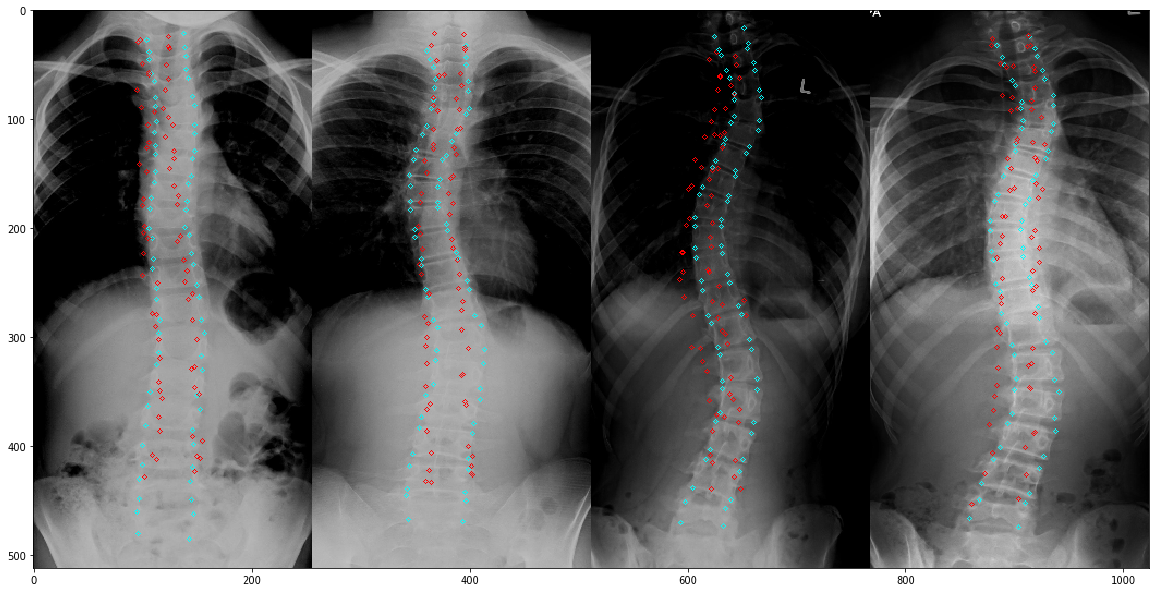

In [15]:
plt.imshow(batch_img)